# 5-4 TensorBoard可视化

在我们的炼丹过程中，如果能够使用丰富的图像来展示模型的结构，指标的变化，参数的分布，输入的形态等信息，无疑会提升我们对问题的洞察力，并增加许多炼丹的乐趣。

TensorBoard正是这样一个神奇的炼丹可视化辅助工具。它原是TensorFlow的小弟，但它也能够很好地和Pytorch进行配合。甚至在Pytorch中使用TensorBoard比TensorFlow中使用TensorBoard还要来的更加简单和自然。

Pytorch中利用TensorBoard可视化的大概过程如下：

首先在Pytorch中指定一个目录创建一个torch.utils.tensorboard.SummaryWriter日志写入器。

然后根据需要可视化的信息，利用日志写入器将相应信息日志写入我们指定的目录。

最后就可以传入日志目录作为参数启动TensorBoard，然后就可以在TensorBoard中愉快地看片了。

我们主要介绍Pytorch中利用TensorBoard进行如下方面信息的可视化的方法。

* 可视化模型结构： writer.add_graph

* 可视化指标变化： writer.add_scalar

* 可视化参数分布： writer.add_histogram

* 可视化原始图像： writer.add_image 或 writer.add_images

* 可视化人工绘图： writer.add_figure

## 一、可视化模型结构

In [1]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torchkeras import Model, summary

In [5]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.dropout = nn.Dropout(p=0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y

In [6]:
net = Net()

In [7]:
summary(net, input_shape=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
           Dropout-4           [-1, 64, 11, 11]               0
 AdaptiveMaxPool2d-5             [-1, 64, 1, 1]               0
           Flatten-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 1]              33
          Sigmoid-10                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forward/backward pass size (MB): 0.394302
Params size (MB): 0.207035
E

In [11]:
log_dir = "./log/5_5_tensorboard"
writer = SummaryWriter(log_dir)

In [12]:
writer.add_graph(net, input_to_model=torch.rand(1, 3, 32, 32))
writer.close()

In [10]:
# 启动tensorboard
%load_ext tensorboard
%tensorboard --logdir ./log/5_5_tensorboard

## 二、可视化指标变化
有时候需要在训练过程中, 实时看到loss和各种metric的变化曲线。

注意, writer.add_scalar仅能对标量的值进行可视化。因此它一般用于对loss和metric的变化进行可视化。

In [13]:
# f(x) = x**2 - 2*x + 1的最小值
x = torch.tensor(0.0, requires_grad=True)
a = torch.tensor(1.0)
b = torch.tensor(-2.0)
c = torch.tensor(1.0)

In [14]:
optim = torch.optim.SGD(params=[x], lr = 0.01)

def f(x):
    return a*x**2 + b*x + c

In [15]:
for i in range(500):
    optim.zero_grad()
    y = f(x)
    y.backward()
    optim.step()
    writer.add_scalar("x", x.item(), i)
    writer.add_scalar("y", y.item(), i)
writer.close()
print("y=", f(x).detach(), ";", "x=", x.detach())

y= tensor(0.) ; x= tensor(1.0000)


## 三、可视化参数分布
如果需要对模型的参数在训练过程中的变化进行可视化, 可以使用add_histogram。

它能够观测张量值分布的直方图随训练步骤变化的趋势。

In [16]:
def norm(mean, std):
    t = std*torch.randn((100, 20)) + mean
    return t

for step, mean in enumerate(range(-10, 10, 1)):
    w = norm(mean, 1)
    writer.add_histogram("w", w, step)
    writer.flush()
    
writer.close()

## 四、可视化原始图像
如果我们做图像相关任务的时候, 可以将原始图像在tensorboard中进行展示。

如果只写入一张图像信息, 可以使用add_image。

如果写入多张图像信息, 可以使用add_images

也可以用torchvision.utils.make_grid将多个图片拼接成一张, 然后用add_image写入。

In [25]:
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets 
import torchvision

In [19]:
transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_valid = transforms.Compose([
    transforms.ToTensor()
])

In [20]:
ds_train = datasets.ImageFolder("./data/cifar2/train",
                                transform=transform_train,
                               target_transform=lambda t: torch.tensor([t]).float())
ds_valid = datasets.ImageFolder("./data/cifar2/test",
                                transform=transform_valid,
                               target_transform=lambda t: torch.tensor([t]).float())
print(ds_train.class_to_idx)

{'0_airplane': 0, '1_automobile': 1}


In [21]:
dl_train = DataLoader(ds_train, batch_size=8, shuffle=True, num_workers=1)
dl_valid = DataLoader(ds_valid, batch_size=8, shuffle=True, num_workers=1)

In [22]:
images, labels = next(iter(dl_train))

In [23]:
# 仅看一张图片
writer.add_image("images[0]", images[0])
writer.close()

In [26]:
# 将多张图片拼接为一张图片
img_grid = torchvision.utils.make_grid(images)
writer.add_image("image_grid", img_grid)
writer.close()

## 五、可视化人工绘图
如果我们将matplotlib绘图的结果在tensorboard中展示, 可以使用add_figure

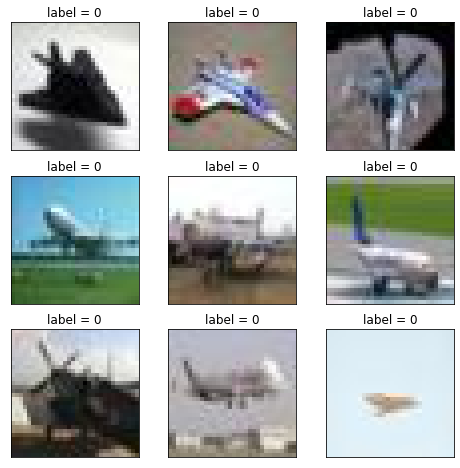

In [30]:
from matplotlib import pyplot as plt

figure = plt.figure(figsize=(8, 8))

for i in range(9):
    img, label = ds_train[i]
    img = img.permute(1, 2, 0)
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = {:d}".format(int(label.item())))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [33]:
writer.add_figure("figure", figure, global_step=1)
writer.close()